In [1]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
# !pip install ipywidgets
# !pip install yfinance

import warnings
import yfinance as yf
import pandas as pd
import time
import datetime
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings(action='ignore')

class YFinance():
    def __init__(self, tickers, period):
        self.period = period

        self.df_price = pd.DataFrame()
        self.df_dividends = pd.DataFrame()
        for ticker in tickers:
            try:
                full_data = yf.Ticker(ticker).history(start=self.period[0], end=self.period[1])
                self.df_price[ticker] = full_data['Close']
                self.df_dividends[ticker] = full_data['Dividends']
                time.sleep(0.5)
            except:
                self.df_price[ticker] = 1
                self.df_dividends[ticker] = 0
                continue



    def get_price(self):
        return self.df_price

    def get_dividends(self):
        return self.df_dividends



In [2]:
tickers = {
    'NVDA', 'LLY'
}

In [3]:
years = 10

today = datetime.datetime.now()
start_date = today - datetime.timedelta(days=365*years)
end_date = today
date_range = int(-1 * 365 / 7 * 5 * years)

In [4]:
y_finance = YFinance(tickers=tickers, period=(start_date, end_date))
yf_price = y_finance.get_price()[date_range:]
yf_price = yf_price.fillna(1)
yf_price.columns = tickers

yf_dividends = y_finance.get_dividends()[date_range:]
yf_dividends = yf_dividends.fillna(0.0)
yf_dividends.columns = yf_price.columns

In [5]:
price_rate = yf_price/yf_price.iloc[0]
rate = price_rate.iloc[-1].sort_values(ascending = False)
rate

NVDA    274.927931
LLY      13.295064
Name: 2024-11-29 00:00:00-05:00, dtype: float64

In [6]:
target = rate[rate.values > 1]
target

NVDA    274.927931
LLY      13.295064
Name: 2024-11-29 00:00:00-05:00, dtype: float64

In [7]:
target = rate[rate.values > 20]
target

NVDA    274.927931
Name: 2024-11-29 00:00:00-05:00, dtype: float64

In [8]:
print(1.05**years)

1.628894626777442


In [9]:
#최소 연 복리 5%
target = rate[rate.values > 1.05**years]
target

NVDA    274.927931
LLY      13.295064
Name: 2024-11-29 00:00:00-05:00, dtype: float64

In [10]:
tickers = list(target.index)
len(tickers)

2

In [11]:
# 다시 시작
y_finance = YFinance(tickers=tickers, period=(start_date, end_date))
yf_price = y_finance.get_price()[date_range:]
yf_price = yf_price.fillna(1)
yf_price.columns = tickers

yf_dividends = y_finance.get_dividends()[date_range:]
yf_dividends = yf_dividends.fillna(0.0)
yf_dividends.columns = yf_price.columns

In [12]:
total_size = 10000

port_ratios = []
port_returns = np.array([])
port_risks = np.array([])
for i in tqdm(range(total_size)): # 포트폴리오 비율 조합 100000개
    # 포트폴리오 비율
    port_ratio = np.random.rand(len(yf_price.columns)) # 랜덤 실수 조합
    port_ratio /= port_ratio.sum() # 합계가 1인 랜덤 실수
    port_ratios.append(port_ratio)

    # 연 평균 수익률
    total_return_rate = (yf_price.iloc[-1] + yf_dividends.sum()) / yf_price.iloc[0] # 배당금 합산 총 수익률(%)
    annual_avg_rr = total_return_rate ** (1/10) # 연 (기하)평균 수익률(%)
    port_return = np.dot(port_ratio, annual_avg_rr-1) # 연 평균 포트폴리오 수익률 = 연 평균 수익률과 포트폴리오 비율의 행렬곱
    port_returns = np.append(port_returns, port_return)

    # 연간 리스크
    annual_cov = yf_price.pct_change().cov() * len(yf_price)/10 # 연간 수익률의 공분산 = 일별 수익률 공분산 * 연간 평균 거래일수
    port_risk = np.sqrt(np.dot(port_ratio.T, np.dot(annual_cov, port_ratio))) # E(Volatility) = sqrt(WT*COV*W)
    port_risks = np.append(port_risks, port_risk)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
sorted_shape_idx = np.argsort(port_returns/port_risks)
sorted_risk_idx = np.argsort(port_risks)

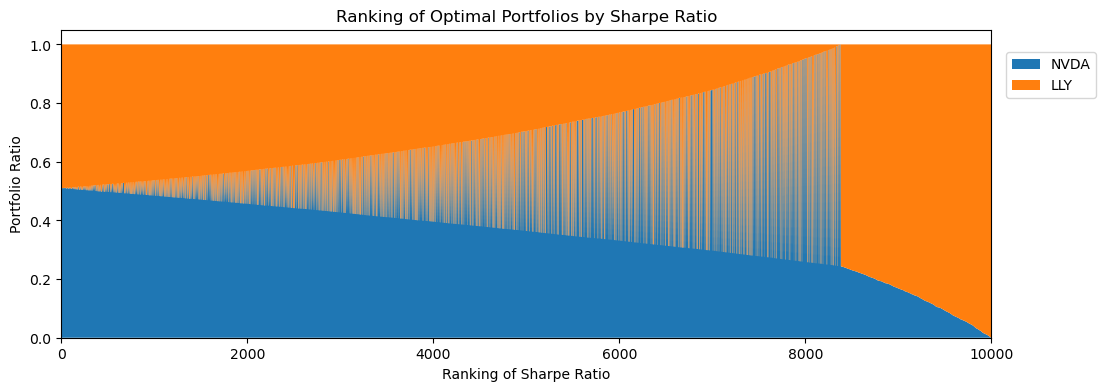

In [14]:
port_df = pd.DataFrame(port_ratios)
sorted_port_df = port_df.iloc[sorted_shape_idx[::-1]] # 역순
sorted_port_df.columns = yf_price.columns

plt.figure(figsize=(12,4))
plt.stackplot(np.arange(1,len(sorted_port_df)+1,1), np.array(sorted_port_df.T), labels=sorted_port_df.columns)

plt.xlim(0,10000)
plt.legend(bbox_to_anchor=(1.12,0.95))
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Portfolio Ratio')
plt.title('Ranking of Optimal Portfolios by Sharpe Ratio')
plt.show()

In [15]:
sorted_returns = port_returns[[sorted_port_df.index]]
sorted_risks = port_risks[[sorted_port_df.index]]

In [16]:
sorted_risks

array([[0.30905406, 0.30904037, 0.30902128, ..., 0.27834378, 0.27835197,
        0.27835837]])

In [17]:
sorted_returns = port_returns[[sorted_port_df.index]][0]
sorted_risks = port_risks[[sorted_port_df.index]][0]

In [18]:
sorted_returns[0]

0.5315526193483746

In [19]:
sorted_risks[0]

0.3090540558365276

In [20]:
returns_per = (sorted_returns[0])
risks_per = (sorted_risks[0])

score_now = ((returns_per - risks_per - (returns_per * risks_per)))
print("score: ",score_now * 100)

score:  5.822007061170193


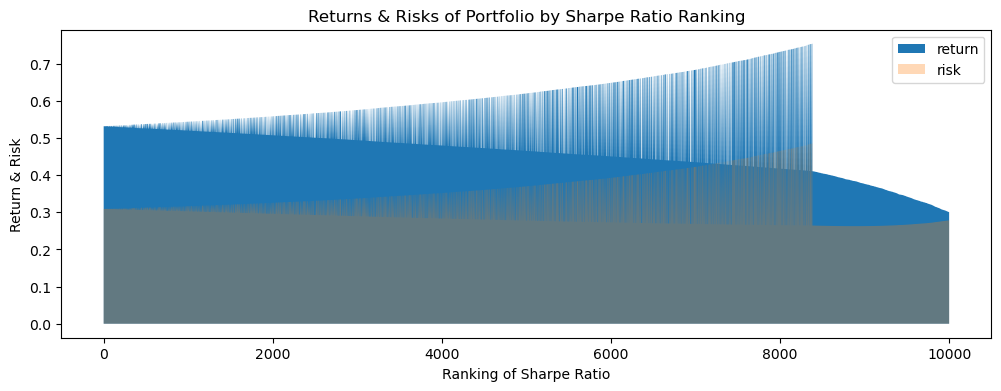

In [21]:
sorted_returns = port_returns[[sorted_port_df.index]][0]
sorted_risks = port_risks[[sorted_port_df.index]][0]

plt.figure(figsize=(12,4))
plt.fill_between(x=np.arange(1,len(sorted_returns)+1,1), y1=sorted_returns.tolist(), label='return')
plt.fill_between(x=np.arange(1,len(sorted_risks)+1,1), y1=sorted_risks.tolist(), alpha=0.3, label='risk')
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Return & Risk')
plt.title('Returns & Risks of Portfolio by Sharpe Ratio Ranking')
plt.legend()
plt.show()

In [22]:
result_list = (sorted_port_df.iloc[0]).sort_values(ascending = False)
result_list

NVDA    0.510024
LLY     0.489976
Name: 656, dtype: float64

In [28]:
size = 100000

sum = 0
for i in range(len(sorted_port_df.iloc[0])):
    name = sorted_port_df.iloc[0].index[i]
    value =  round(sorted_port_df.iloc[0][i] * size)
    if value >= 1000:
        print(name, value)
        sum += value
print()
print('총 비용', sum)

NVDA 51002
LLY 48998

총 비용 100000


In [24]:
x = 1000 / ((sorted_port_df.iloc[0]).sort_values(ascending = True))[0]
x

2040.9176818131464

In [25]:
# 최소 비중의 주식을 1000으로 잡고 계산
result_list = (sorted_port_df.iloc[0]).sort_values(ascending = False)

flag = False

sum = 0
rest_sum = 0

for i in range(len(result_list)):
    name = result_list.index[i]
    value =  (round(result_list[i] * x))
    if (value < 1000):
        if (flag == False):
            print("===========")
            flag = True
        rest_sum += value
    print(name, value)
    sum += value
    
print()
print('총 비용', sum - rest_sum)

NVDA 1041
LLY 1000

총 비용 2041
